In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('file (2)', )

In [3]:
columns0 = ['price','rarity', 'color_identity','colors','mana_cost','cmc','power','toughness','type_line', 'released_at', 'flavor_text']
df = df[columns0]

In [4]:
df['type_line'] = [x.split(sep='—')[0].split(sep='//')[0].strip() for x in df['type_line']]

In [5]:
color_combos = pd.Series(df['colors'].value_counts().index.tolist()).apply(lambda x : eval(x)).to_dict()
color_combos_strings = pd.Series(df['colors'].value_counts().index.tolist()).to_dict()
color_combos_strings  = dict (zip(color_combos_strings.values(),color_combos_strings.keys()))
color_identities = pd.Series(df['color_identity'].value_counts().index.tolist()).apply(lambda x : eval(x)).to_dict()
color_identities_strings = pd.Series(df['color_identity'].value_counts().index.tolist()).to_dict()
color_identities_strings = dict (zip(color_identities_strings.values(),color_identities_strings.keys()))
rarities_dict = {'common':0, 'uncommon':1, 'rare':2, 'mythic':3}

In [6]:
df['color_identity'] = df['color_identity'].map(color_identities_strings)
df['colors'] = df['colors'].map(color_combos_strings)
df['rarity'] = df['rarity'].map(rarities_dict)

flav_len = []

for x in df['flavor_text']:
    if(type(x) == float):
        flav_len.append(0)
    else:
        flav_len.append(len(x))
        
df['flav_len'] = flav_len

In [7]:
df['released_at'] = pd.to_datetime(df['released_at'])

In [8]:
df['release_y'] = [x.year for x in df['released_at']]
df['release_m'] = [x.month for x in df['released_at']]
df['released_at'] = [str(x.year)+str(x.month) for x in df['released_at']]

In [9]:
df

,price,rarity,color_identity,colors,mana_cost,cmc,power,toughness,type_line,released_at,flavor_text,flav_len,release_y,release_m
0,0.18,2,0,0,{3}{W},4.0,NaN,NaN,Sorcery,20195,The heart of Ravnica disappeared before anyone...,82,2019,5
1,0.44,1,1,1,{U},1.0,1,1,Creature,20191,NaN,0,2019,1
2,6.45,1,4,4,{G},1.0,NaN,NaN,Instant,20197,NaN,0,2019,7
3,0.03,0,3,3,{2}{R}{R},4.0,4,3,Creature,20197,Keldon raiders' spoils are limited to what the...,113,2019,7
4,0.44,2,4,4,{G}{G}{G},3.0,0,0,Legendary Creature,201910,NaN,0,2019,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364,0.11,0,2,2,{B}{B},2.0,NaN,NaN,Instant,20197,"""All your steel won't protect you if your will...",56,2019,7
1365,0.26,1,1,1,{2}{U}{U},4.0,2,2,Creature,20195,"""Pardon me if I seem distracted. Part of me is...",82,2019,5
1366,3.76,2,4,4,{X}{G}{G},2.0,0,1,Creature,20197,NaN,0,2019,7
1367,0.03,0,1,1,{4}{U},5.0,3,5,Creature,20195,"""Fear writhes and whispers in the shadows of y...",108,2019,5


In [10]:
target = 'price'
features = df.columns.drop(target)

In [11]:
df = df.loc[df['price'] <= 10.0]
df = df.reset_index().drop(['index'],axis =1);

In [12]:
import category_encoders as ce

encoder = ce.OrdinalEncoder()

df = encoder.fit_transform(df)

In [13]:
#df['price'] = df['price'].apply(lambda x: x*100)
df['price'] = np.log1p(df['price'])

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size= .80, test_size= .20, random_state=0)
train, val = train_test_split(train, train_size= .80, test_size= .20, random_state=0)

In [15]:
print(len(train), len(val), len(test))
len(train) + len(val) + len(test), len(df)

758 190 238


(1186, 1186)

In [56]:
758/1186

0.6391231028667791

In [57]:
190/1186

0.16020236087689713

In [58]:
238/1186

0.20067453625632378

In [16]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [69]:
def plot_importances(model, X_train, feat_quant):
    importances = pd.Series(model.feature_importances_, X_train.columns)

    # Plot feature importances
    %matplotlib inline
    import matplotlib.pyplot as plt

    n = feat_quant
    plt.figure(figsize=(10,n/2))
    plt.title(f'Top {n} Features')
    importances.sort_values()[-n:].plot.barh(color='grey');

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

def print_evaluation(model, X_val, y_val, X_test, y_test):
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    print('Val_score MSE:\t'+str(mean_squared_error(y_val, val_pred )))
    print('Val_score MAE:\t'+str(median_absolute_error(y_val, val_pred)))
    print('\nVal_score EVS:\t'+str(explained_variance_score(y_val, val_pred)))
    print('Val_score r2:\t'+str(r2_score(y_val, val_pred)))
    print('\nTest_score MSE:\t'+str(mean_squared_error(y_test, test_pred)))
    print('Test_score MAE:\t'+str(median_absolute_error(y_test, test_pred)))
    print('\nTest_score EVS:\t'+str(explained_variance_score(y_test, test_pred)))
    print('Test_score r2:\t'+str(r2_score(y_test, test_pred)))
    
    val_dict = {'mse': mean_squared_error(y_val, val_pred ),
               'mae': median_absolute_error(y_val, val_pred),
               'r2': r2_score(y_val, val_pred)}
    
    test_dict = {'mse': mean_squared_error(y_test, test_pred),
               'mae': median_absolute_error(y_test, test_pred),
               'r2': r2_score(y_test, test_pred)}
    
    return val_dict, test_dict

In [18]:
from sklearn.dummy import DummyRegressor

In [19]:
dummy_mean = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy_mean.fit(X_train, y_train)

dummy_val_eval, dummy_test_eval = print_evaluation(dummy_mean, X_val, y_val, X_test, y_test)

Val_score MSE:	0.26426934298718585
Val_score MAE:	0.27470715285087466

Val_score EVS:	0.0
Val_score r2:	-0.003255598039607177

Test_score MSE:	0.25345580395173456
Test_score MAE:	0.27949187835895

Test_score EVS:	0.0
Test_score r2:	-0.0020998085357184504


In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
# from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV


param_distributions = { 
    'xgbregressor__n_estimators': list(range(0,100,10)),
    'xgbregressor__max_depth': list(range(2,10,2)), 
    'xgbregressor__learning_rate': [x/10 for x in list(range(1, 5))]
}

pipeline = make_pipeline(
            StandardScaler(),
            XGBRegressor(
                reg='squarederror',
                n_estimators=200, 
                max_depth=10,       
                learning_rate=0.5, 
                n_jobs=-1,
                random_state=0,
                verbosity= 1,
                verbose = True)
)

search = GridSearchCV(
    pipeline, 
    param_grid=param_distributions
    )
    
search.fit(X_train, y_train);
    
[search.best_params_,-search.best_score_]

[23:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:58:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:59:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[{'xgbregressor__learning_rate': 0.2,
  'xgbregressor__max_depth': 2,
  'xgbregressor__n_estimators': 80},
 -0.4842090588008097]

[01:56:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Val_score MSE:	0.12035860566603304
Val_score MAE:	0.13154170496730305

Val_score EVS:	0.5436277662063641
Val_score r2:	0.5430781204441701

Test_score MSE:	0.09462939943356202
Test_score MAE:	0.10900239644409848

Test_score EVS:	0.6260923863489922
Test_score r2:	0.6258594138476284
[01:56:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[-0.10982136 -0.1280600

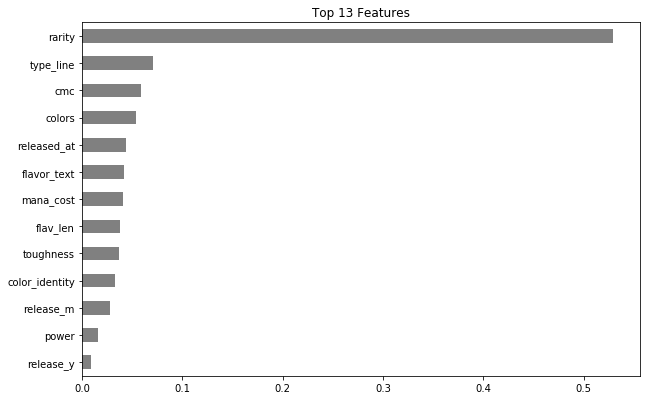

In [89]:
best_xgbr = make_pipeline(
            StandardScaler(),
            XGBRegressor(
                reg='squarederror',
                n_estimators=80, 
                max_depth=2,       
                learning_rate=0.2, 
                n_jobs=-1,
                random_state=0,
                verbosity= 1,
                verbose = True)
)

best_xgbr.fit(X_train, y_train)

xgbr_val_eval, xgbr_test_eval = print_evaluation(best_xgbr, X_val, y_val, X_test, y_test)

scores = cross_val_score(best_xgbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print(scores)

xgbr = best_xgbr.named_steps['xgbregressor']
plot_importances(xgbr, X_train, 13)

In [24]:
from sklearn.ensemble import RandomForestRegressor

param_distributions = { 
    'randomforestregressor__n_estimators': list(range(10,100,10)),
    'randomforestregressor__max_depth': list(range(2,10,2)), 
}

pipeline = make_pipeline(
            RandomForestRegressor(
                n_estimators=200, 
                max_depth=10,  
                n_jobs=-1,
                random_state=0,
                verbose= True)
)

search = GridSearchCV(
    pipeline,
    param_grid=param_distributions
    )

search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  73 out of  80 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  73 out of  80 | e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=10,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
 

In [25]:
print([search.best_params_,-search.best_score_])

[{'randomforestregressor__max_depth': 6, 'randomforestregressor__n_estimators': 80}, -0.48055499586475514]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished


Val_score MSE:	0.12048983370318034
Val_score MAE:	0.09038065969162751

Val_score EVS:	0.5448538732922148
Val_score r2:	0.5425799345350533

Test_score MSE:	0.09545836379797029
Test_score MAE:	0.08704958866863446

Test_score EVS:	0.6231316908825023
Test_score r2:	0.6225818995121719
[01:56:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[-0.10982136 -0.12806001 -0.13396687 -0.17021095 -0.08990825]


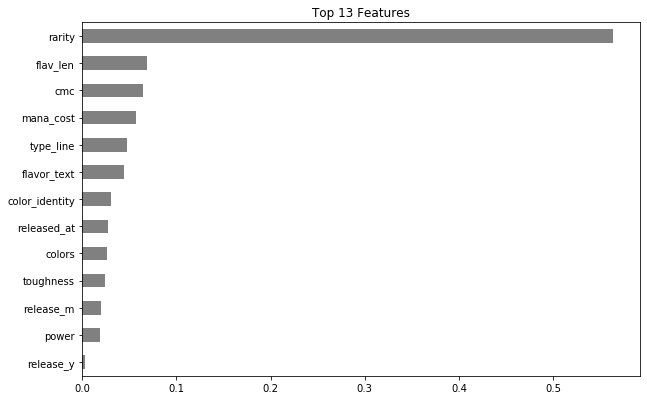

In [88]:
best_rfr = make_pipeline(
            RandomForestRegressor(
                n_estimators=80, 
                max_depth=6,        
                n_jobs=-1,
                random_state=0,
                verbose = True)
)

best_rfr.fit(X_train, y_train)

rfr_val_eval, rfr_test_eval = print_evaluation(best_rfr, X_val, y_val, X_test, y_test)

scores = cross_val_score(best_xgbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print(scores)

rfr = best_rfr.named_steps['randomforestregressor']
plot_importances(rfr, X_train, 13)

In [92]:
from sklearn.linear_model import LinearRegression

pipeline = make_pipeline(
            StandardScaler(),
            LinearRegression()
)

pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))

lr_val_eval, lr_test_eval = print_evaluation(pipeline, X_val, y_val, X_test, y_test)

linreg = pipeline.named_steps['linearregression']
linreg.coef_

0.411736893432381
Val_score MSE:	0.141941338972894
Val_score MAE:	0.18028352351129165

Val_score EVS:	0.4612644887938685
Val_score r2:	0.4611427821777332

Test_score MSE:	0.12271940397956956
Test_score MAE:	0.18663186563516387

Test_score EVS:	0.5154626145236552
Test_score r2:	0.5147986776623091


array([ 0.30851951,  0.02087013, -0.04801303, -0.00543238, -0.0472803 ,
        0.01424593,  0.00531324,  0.04845185,  0.01677076, -0.01797363,
       -0.00268901,  0.05496715,  0.04378364])

0.4927876560423228
Val_score MSE:	0.11750400201930211
Val_score MAE:	0.09002683428291486

Val_score EVS:	0.5553903220117961
Val_score r2:	0.5539151591123518

Test_score MSE:	0.10173640803674908
Test_score MAE:	0.09002683428291486

Test_score EVS:	0.5989943493371972
Test_score r2:	0.5977601087637658


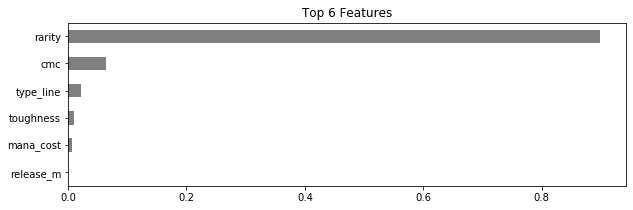

In [87]:
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(
            DecisionTreeRegressor(
                max_depth=3
            )
)

pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))

dtr_val_eval, dtr_test_eval = print_evaluation(pipeline, X_val, y_val, X_test, y_test)

dtr = pipeline.named_steps['decisiontreeregressor']
plot_importances(dtr, X_train, feat_quant= 6)

In [144]:
import shap

row_id = 0

row = X_test.iloc[row_id]
print(np.expm1(y_test.iloc[row_id]))

explainer = shap.TreeExplainer(xgbr)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    #link='logit' # For classification, this shows predicted probabilities
)

2.6299999999999994


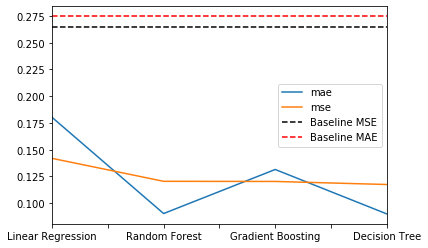

In [140]:
xgbr_val_eval#, xgbr_test_eval
rfr_val_eval#, rfr_test_eval
dtr_val_eval#, dtr_test_eval
lr_val_eval#, lr_test_eval

evals= pd.DataFrame(data=[xgbr_val_eval, rfr_val_eval, dtr_val_eval, lr_val_eval],
                    index=['Gradient Boosting',
                           'Random Forest',
                           'Decision Tree',
                           'Linear Regression'])


ax = evals.sort_values(by='r2')[['mae','mse']].plot()
ax.axhline(y=0.26426934298718585, label= 'Baseline MSE', c='black', linestyle='--')
ax.axhline(y=0.27470715285087466, label='Baseline MAE', c= 'red', linestyle='--')

ax.legend()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2826bf6b630>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2826c030080>})

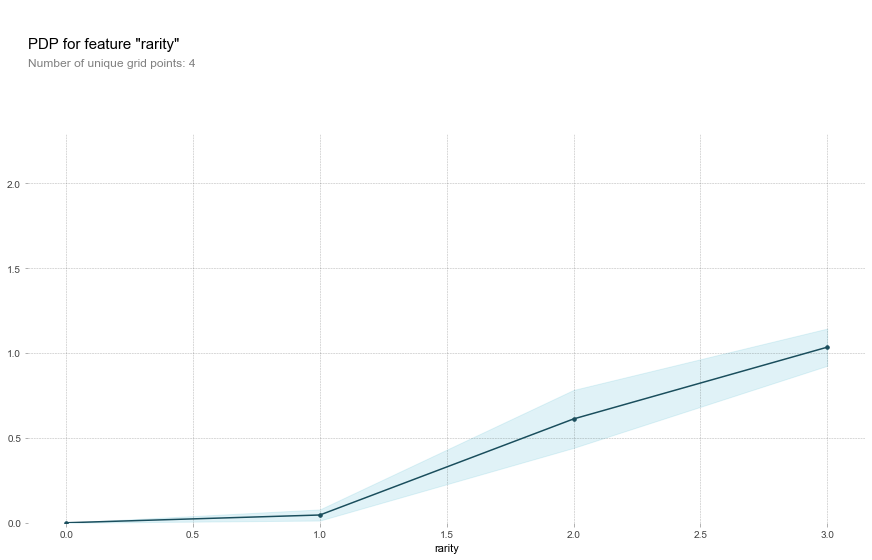

In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot

features_0 = 'rarity'

isolated = pdp_isolate(
    model=rfr, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=features_0
)

pdp_plot(isolated, feature_name=features_0)

In [32]:
import seaborn as sns


In [33]:
x_s = df.columns.drop('price')
y_s = 'price'

print(x_s)

Index(['rarity', 'color_identity', 'colors', 'mana_cost', 'cmc', 'power',
       'toughness', 'type_line', 'released_at', 'flavor_text', 'flav_len',
       'release_y', 'release_m'],
      dtype='object')


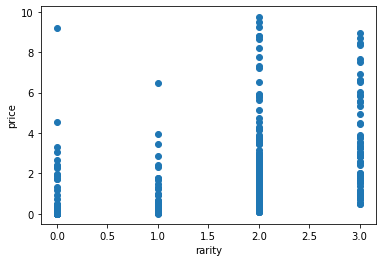

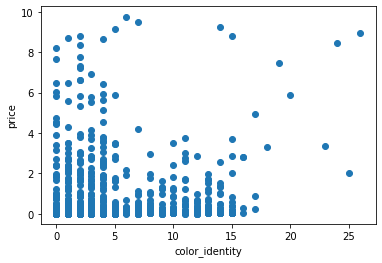

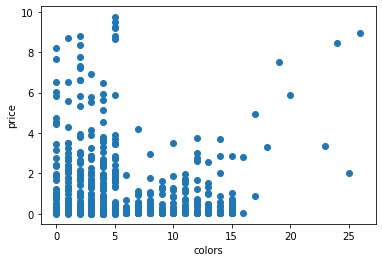

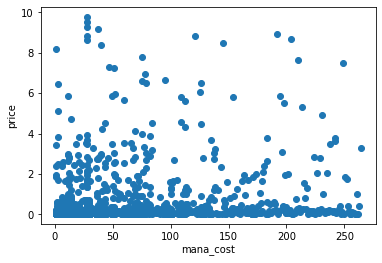

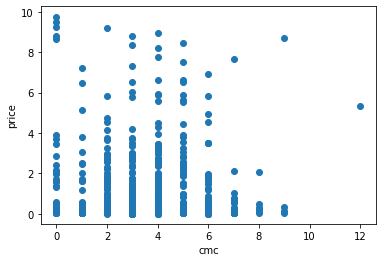

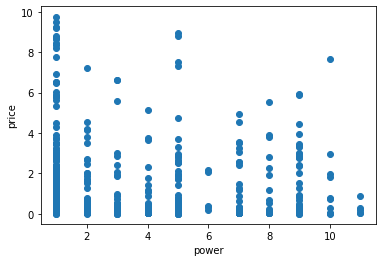

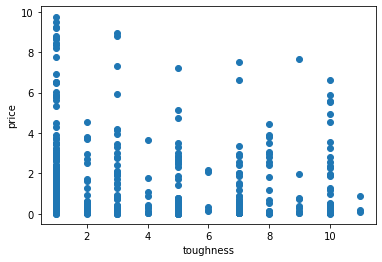

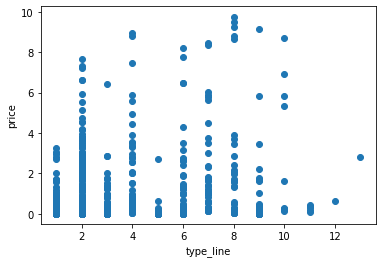

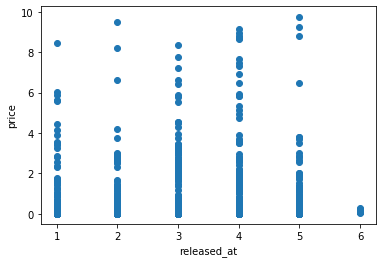

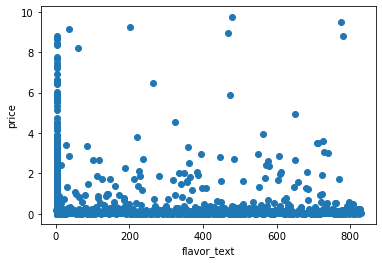

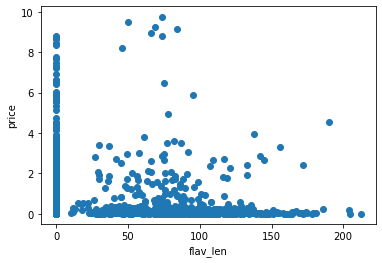

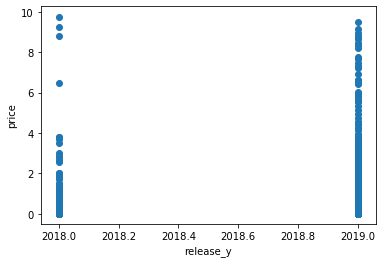

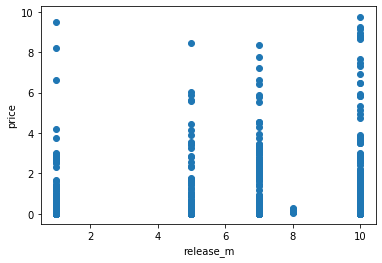

In [172]:
import matplotlib.pyplot as plt

df['price'] = np.expm1(df['price'])

plots = []

for x in x_s:
    fig, ax = plt.subplots()
    ax.scatter(x= df[x],y= df[y_s])
    ax.set_xlabel(x)
    ax.set_ylabel('price')
    fig.add_axes(ax)
    plots.append(fig)

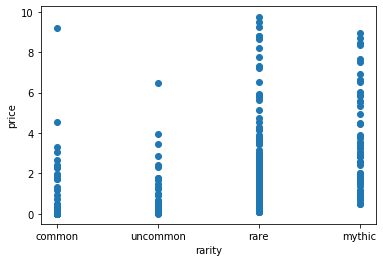

In [173]:
fig = plots[0]
ax = fig.axes[0]
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(rarities_dict)
fig